In [1]:
import os
import numpy as np
import geopandas as gpd
import pandas as pd
from joblib import Parallel, delayed
import shapely as sh
from shapely import wkt
from pyproj import CRS
from progressbar import progressbar as pbar
import rasterio
import geoplot as gplt
import matplotlib as mpl
from rlxutils import subplots
epsg4326 = CRS.from_epsg(4326)
import matplotlib.pyplot as plt

In [56]:
chipsets_file = "/opt/earthdata/chipsets-definitions.parquet"
basedir = "/opt/earthdata/chipsets"
dataset = "s1counts-2022"

In [57]:
cs = gpd.read_parquet(chipsets_file)
cs.shape

(1005, 1)

In [58]:
level_files = [f for f in os.listdir("../data") if f.startswith("luxembourg") and f.endswith(".wkt") and "_L" in f]

In [59]:
levels = {}
for level_file in level_files:
    with open(f"../data/{level_file}") as f:
        s = wkt.load(f)
    levels[level_file.split(".")[0].split("_")[-1]] = s

In [60]:
all_levels = sh.ops.unary_union(list(levels.values()))
luxc = cs[[gi.intersects(all_levels) for gi in cs.geometry]]
luxc

,geometry
tile_id,
25cffb64f0953,"POLYGON ((0.00000 49.35156, 0.00481 49.35306, ..."
142f3a38257ca,"MULTIPOLYGON (((0.00000 53.56041, 0.01059 53.5..."
28c7b4b0200d2,"POLYGON ((5.00000 50.00000, 10.00000 50.00000,..."
19f5ef11e7a2a,"MULTIPOLYGON (((5.00000 52.96047, 5.03550 52.9..."
27279556b1c94,"MULTIPOLYGON (((10.00000 50.00000, 15.00000 50..."
192735d71fee9,"MULTIPOLYGON (((10.00000 54.49856, 10.12192 54..."


In [61]:
cc = c

In [62]:
# load chipsets and check chips downloaded
chips = {}
for chipset_id in pbar(luxc.index):
    #if not '19273' in chipset_id:
    #    continue
    chipset_defs_file = [f for f in os.listdir(basedir) if chipset_id in f and f.endswith('.geojson')][0]
    chipset_defs_filepath = f"{basedir}/{chipset_defs_file}"
    dataset_folder = chipset_defs_filepath[:-8] + "/" + dataset
    c = gpd.read_file(chipset_defs_filepath)
    c['dataset_folder'] = dataset_folder
    c['downloaded'] = [os.path.isfile(f"{dataset_folder}/{identifier}.tif") for identifier in c.identifier]
    chips[chipset_id] = c
    

100% (6 of 6) |##########################| Elapsed Time: 0:00:07 Time:  0:00:070:01


In [51]:
!ls $dataset_folder|wc

ls: cannot access '/opt/earthdata/chipsets/192735d71fee9_partitions_aschips_23e56e19be562/s1grdo-202201': No such file or directory
      0       0       0


In [52]:
c = pd.concat(chips.values())
c.downloaded.sum()

88

In [53]:
c[c.identifier=='0a1aec282d4b8']

,area_km2,identifier,group,geometry,dataset_folder,downloaded
1,26.240204,0a1aec282d4b8,0,"POLYGON ((-0.03375 45.00111, -0.03375 45.04719...",/opt/earthdata/chipsets/25cffb64f0953_partitio...,False


In [54]:
c[c.downloaded].dataset_folder.value_counts()

dataset_folder
/opt/earthdata/chipsets/28c7b4b0200d2_partitions_aschips_37a99155eb305/s1grdo-202201    74
/opt/earthdata/chipsets/19f5ef11e7a2a_partitions_aschips_074be7bb83d5c/s1grdo-202201    14
Name: count, dtype: int64

In [ ]:
z = []
for _,row in pbar(c[c.downloaded].iterrows()):
    chip_file = f"{dataset_folder}/{row.identifier}.tif"
    if row.identifier=='0a1aec282d4b8':
        ads
    try:
        with rasterio.open(chip_file) as rf:
            x = rf.read()
            rrow = {k:v for k,v in zip(rf.descriptions, x.mean(axis=1).mean(axis=1).astype(int))}
        rrow['geometry'] = row.geometry.centroid    
        z.append(rrow)
    except Exception as e:
        raise e
z = gpd.GeoDataFrame(z, crs=epsg4326)
z.shape

/ |#                                                  | 0 Elapsed Time: 0:00:00

RasterioIOError: /opt/earthdata/chipsets/192735d71fee9_partitions_aschips_23e56e19be562/s1grdo-202201/2a1375d66097c.tif: No such file or directory

In [14]:
!ls /opt/earthdata/chipsets/192735d71fee9_partitions_aschips_23e56e19be562/s1count-2022/0a1aec282d4b8.tif

ls: cannot access '/opt/earthdata/chipsets/192735d71fee9_partitions_aschips_23e56e19be562/s1count-2022/0a1aec282d4b8.tif': No such file or directory


In [199]:
c[c.downloaded].shape

(19152, 6)

In [201]:
max_count = z[[col for col in z.columns if col!='geometry']].values.max()

In [ ]:
xy = np.r_[[list(gi.coords)[0] for gi in z.geometry.values]]


for ax,col in pbar(subplots([col for col in z.columns if col!='geometry'], n_cols=8)):
    plt.scatter(xy[:,0], xy[:,1], s=10, alpha=.5, c=z[col].values, cmap=plt.cm.cool, vmin=0, vmax=max_count)
    plt.colorbar()
    plt.axis('off')
    plt.title(col)
    

In [71]:
x = rf.read()

In [83]:
rrow = {k:v for k,v in zip(rf.descriptions, x.mean(axis=1).mean(axis=1).astype(int))}
rrow['geometry'] = row.geometry.centroid

In [78]:
x.mean(axis=1).mean(axis=1).astype(int)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 5, 4, 5, 5, 5, 5, 4, 5,
       4, 5, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 4, 5, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5])

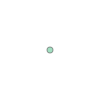

In [80]:
row.geometry.centroid

In [66]:
!ls $chip_file

/opt/earthdata/chipsets/192735d71fee9_partitions_aschips_23e56e19be562/s1count-2022/1c9eb1f046698.tif


In [ ]:
c[c.downloaded].explore(style_kwds=dict(color="black",weight=.5, opacity=.5, fillOpacity=.3))

In [223]:
dataset_folder

'/opt/earthdata/chipsets/192735d71fee9_partitions_aschips_23e56e19be562/s1grd-2021'

In [52]:
cl.head()

,area_km2,identifier,group,geometry
0,26.240088,0dc19ddf788ec,15,"POLYGON ((-0.03132 44.95508, -0.03132 45.00117..."
1,26.240204,0a1aec282d4b8,0,"POLYGON ((-0.03375 45.00111, -0.03375 45.04719..."
2,26.240320,04800a35413bc,0,"POLYGON ((-0.03619 45.04714, -0.03619 45.09322..."
3,26.240436,0054dde899256,8,"POLYGON ((-0.03863 45.09316, -0.03863 45.13924..."
4,26.240553,1f7a3f6590c10,16,"POLYGON ((-0.04108 45.13919, -0.04108 45.18527..."


In [54]:
# find existing

In [53]:
np.unique(cl.group.values)

array(['0', '0,L0', '0,L1', '0,L2', '0,L3', '0,L4', '1', '1,L0', '1,L1',
       '1,L2', '1,L3', '1,L4', '10', '10,L0', '10,L1', '10,L2', '10,L3',
       '10,L4', '11', '11,L0', '11,L1', '11,L2', '11,L3', '11,L4', '12',
       '12,L0', '12,L1', '12,L2', '12,L3', '12,L4', '13', '13,L0',
       '13,L1', '13,L2', '13,L3', '13,L4', '14', '14,L0', '14,L1',
       '14,L2', '14,L3', '14,L4', '15', '15,L0', '15,L1', '15,L2',
       '15,L3', '15,L4', '16', '16,L0', '16,L1', '16,L2', '16,L3',
       '16,L4', '17', '17,L0', '17,L1', '17,L2', '17,L3', '17,L4', '18',
       '18,L0', '18,L1', '18,L2', '18,L3', '18,L4', '19', '19,L0',
       '19,L1', '19,L2', '19,L3', '19,L4', '2', '2,L0', '2,L1', '2,L2',
       '2,L3', '2,L4', '3', '3,L0', '3,L1', '3,L2', '3,L3', '3,L4', '4',
       '4,L0', '4,L1', '4,L2', '4,L3', '4,L4', '5', '5,L0', '5,L1',
       '5,L2', '5,L3', '5,L4', '6', '6,L0', '6,L1', '6,L2', '6,L3',
       '6,L4', '7', '7,L0', '7,L1', '7,L2', '7,L3', '7,L4', '8', '8,L0',
       '8,L1', '8,L

In [ ]:
all_levels = sh.ops.unary_union(list(levels.values()))
luxc = cs[[gi.intersects(all_levels) for gi in cs.geometry]]
luxc

,geometry
tile_id,
25cffb64f0953,"POLYGON ((0.00000 49.35156, 0.00481 49.35306, ..."
142f3a38257ca,"MULTIPOLYGON (((0.00000 53.56041, 0.01059 53.5..."
28c7b4b0200d2,"POLYGON ((5.00000 50.00000, 10.00000 50.00000,..."
19f5ef11e7a2a,"MULTIPOLYGON (((5.00000 52.96047, 5.03550 52.9..."
27279556b1c94,"MULTIPOLYGON (((10.00000 50.00000, 15.00000 50..."
192735d71fee9,"MULTIPOLYGON (((10.00000 54.49856, 10.12192 54..."


In [242]:
def chiplevel(geom, levels):
    for l in sorted(list(levels.keys())):
        if levels[l].intersects(geom):
            return l
    return None

for chipset_id in luxc.index:
    
    print (f"adding levels to {chipset_id}")
    
    # look for defs file
    chipset_defs_file = [f for f in os.listdir(basedir) if chipset_id in f and f.endswith('.geojson')]
    if len(chipset_defs_file)==0:
        raise ValueError(f"could not file defs file for {chipset_id}")
    elif len(chipset_defs_file)>1:
        raise ValueError(f"too many defs files for {chipset_id}")

    chipset_defs_file = chipset_defs_file[0]
    chipset_defs_file = f"{basedir}/{chipset_defs_file}"
    c = gpd.read_file(chipset_defs_file)

    
    # add level groups if they havent been added already
    c['level'] = [chiplevel(gi, levels) for gi in c.geometry.values]
    newgroups = []
    for _, row in c.iterrows():
        lgroups = row.group.split(",")
        if row.level is not None and not row.level in lgroups:
            g = ",".join(lgroups + [row.level])  
        else:
            g = row.group
        newgroups.append(g)
    c['group'] = newgroups
    del(c['level'])


adding levels to 25cffb64f0953
adding levels to 142f3a38257ca
adding levels to 28c7b4b0200d2
adding levels to 19f5ef11e7a2a
adding levels to 27279556b1c94
adding levels to 192735d71fee9


In [253]:
chipset_id = luxc.index[2]
chipset_defs_file = [f for f in os.listdir(basedir) if chipset_id in f and f.endswith('.geojson')]
if len(chipset_defs_file)==0:
    raise ValueError(f"could not file defs file for {chipset_id}")
elif len(chipset_defs_file)>1:
    raise ValueError(f"too many defs files for {chipset_id}")

chipset_defs_file = chipset_defs_file[0]
chipset_defs_file = f"{basedir}/{chipset_defs_file}"
c = gpd.read_file(chipset_defs_file)


In [254]:
c['color'] = [ gi.split(",")[1] if len(gi.split(","))>1 else None for gi in c['group'].values]

In [ ]:
c.explore(column='color')